# One Layer Classifier

In [42]:
import numpy as np
import os
np.random.seed(19)

In [58]:
from sklearn import preprocessing
import pickle

class CIFAR10Data():
    def __init__(self):
        self.batches = {}
        self.dataset_dir = '../datasets/'
        self.label_1hot_encoder = preprocessing.LabelBinarizer()
        self.label_1hot_encoder.fit([x for x in range(10)])
        
    def one_hot_encode(self, labels):
        return self.label_1hot_encoder.transform(labels)
    
    def load_batch(self, batch_name):
        
        if batch_name not in self.batches:
            with open(self.dataset_dir + 'cifar-10-batches-py/' + batch_name, 'rb') as f:
                data = pickle.load(f, encoding='bytes')

            data[b'labels'] = np.array(data[b'labels'])
            self.batches[batch_name] = {
                'X': np.divide(data[b'data'], 255),
                'Y': self.one_hot_encode(data[b'labels']),
            }
        # transpose to be dimensionality by number of samples (for OneLayerClassifier)
        return self.batches[batch_name]['X'].T, self.batches[batch_name]['Y'].T
    
    def load_batches(self, batch_names):
        batches = [self.get_batch(batch) for batch in batch_names]
        X = np.vstack([batch[0] for batch in batches])
        Y = np.vstack([batch[1] for batch in batches])
        return X.T, Y.T 

In [195]:
import numpy as np
import scipy
import pickle
import matplotlib.pyplot as plt
from keras.datasets import cifar100
import urllib

class OneLayerClassifer:
    def __init__(self, n_classes, input_dim, batch_size=100, eta=0.001, n_epochs=20, lamda=0):
        self.batch_size = batch_size # number of images in a batch
        self.eta = eta
        self.n_epochs = n_epochs
        self.lamda = lamda
        
        # initialise weight matrix and bias
        self.W = np.random.normal(loc=0, scale=0.01, size=(n_classes, input_dim)) 
        self.b = np.random.normal(loc=0, scale=0.01, size=n_classes)
        

    def normalise(self, train_X, val_X, test_X):
        ''' X has shape (d,n) where d = dimensionality of each image, n is number of images '''
        mean = np.mean(train_X, axis=1)
        std = np.std(train_X, axis=1)
        # apply same transformation to all of the datasets using params from train set
        
        def _normalise_helper(a, m, s):
            return ((a.T-m)/s).T 
        
        train_X = _normalise_helper(train_X, mean, std)
        val_X = _normalise_helper(val_X, mean, std)
        test_X = _normalise_helper(test_X, mean, std)
        return train_X, val_X, test_X

    
    def evaluate_classifier(self, X):
        S = (np.dot(self.W, X).T + self.b).T
        P = self.softmax(S)
        predictions = np.argmax(P)
        return predictions
    

    def softmax(self, x):
        # TODO check axis=0 
        return np.exp(x) / np.sum(np.exp(x), axis=0)
    

    def lcross(self, X, Y, W, b):
        S = np.dot(W, X) + b
        P = self.softmax(S)
        
        l_cross = -np.log(p_y)
        return l_cross
    

    def compute_accuracy(self, X, y):
        ''' X is data, y is gt, W is weight matrix, b is bias'''
        pred = self.evaluate_classifier(X)
        accuracy = np.mean(pred == y)
        return pred, accuracy
    
    
    def compute_cost(self, X, Y, W, b, lamda):
        ''' X: dxn (dimensionality by # images)
            Y: Kxn (no. classes one-hot encoded by # images)
            J: scalar corresponding to sum of loss of ntwks predictions of X relative to gt labels '''
        N = X.shape[1]
        lcross = self.compute_cost(X, Y, W, b)
        J = (np.trace(lcross) / N) + (lamda * np.sum(W*W))
        return J


    def compute_grads_num(self, X, Y, P, W, b, lamda, h):
        """ Converted from matlab code """
        N = W.shape[0]
        D = X.shape[0]

        grad_W = np.zeros(W.shape);
        grad_b = np.zeros((N, 1));

        c = self.compute_cost(X, Y, W, b, lamda);

        for i in range(len(b)):
            print(i)
            b_try = np.copy(b)
            b_try[i] += h
            c2 = self.compute_cost(X, Y, W, b_try, lamda)
            grad_b[i] = (c2-c) / h

        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                W_try = W
                W_try[i,j] += h
                c2 = self.compute_cost(X, Y, W_try, b, lamda)
                grad_W[i,j] = (c2-c) / h

        return grad_W, grad_b

    
    def compute_grads_num_slow(self, X, Y, P, W, b, lamda, h):
        """ Converted from matlab code """
        N = W.shape[0]
        D = X.shape[0]

        grad_W = np.zeros(W.shape);
        grad_b = np.zeros((N, 1));

        for i in range(len(b)):
            b_try = np.copy(b)
            b_try[i] -= h
            c1 = compute_cost(X, Y, W, b_try, lamda)

            b_try = np.copy(b)
            b_try[i] += h
            c2 = compute_cost(X, Y, W, b_try, lamda)

            grad_b[i] = (c2-c1) / (2*h)

        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                W_try = W
                W_try[i,j] -= h
                c1 = compute_cost(X, Y, W_try, b, lamda)

                W_try = W
                W_try[i,j] += h
                c2 = compute_cost(X, Y, W_try, b, lamda)

                grad_W[i,j] = (c2-c1) / (2*h)

        return grad_W, grad_b
    
    def compare_gradients(self, g_n, g_a, eps=0.000001):
        err = np.linalg.norm(g_a-g_n) / np.max(eps, np.linalg.norm(g_a) + np.linalg.norm(g_n))
        print('relative error', err)
        return err
        
    
    def compute_gradients(self, X, Y, W, eta, loss='cross_entropy'):
        ''' computes gradients of the cost function wrt W and b for batch X '''
        # forward pass
        predictions = np.dot(W, X) 
        predicitons = (predictions.T + b).T 
        P = self.softmax(predictions)
        
        # backward pass
        if loss == 'cross_entropy':
            G = -(Y - P)
        elif loss == 'svm':
            G = None # TODO for svm loss
        else:
            raise Exception('incorrect loss') 
            
        batch_size = np.shape(X)[1]
        
        # J = L(D,W,b) + lamda|W|^2
        # dJ/dW = dL/dW + 2 lambda |W| 
        grad_W = (np.dot(G, X.T) /  batch_size) + 2 * self.lamda * W
        grad_b = np.sum(G, axis=1) / batch_size
#         grad_b.reshape((grad_b.shape[0],1))
#         print('grad_b shape', grad_b.shape)
        return grad_W, grad_b
    
    
    def train(self, X, Y, random_shuffle=False):
        n = X.shape[1]
        number_of_batches = int(n / self.batch_size)
        if random_shuffle:
            pass
        
        for epoch in range(self.n_epochs):
            if (epoch % 1000) == 0:
                print('epoch', epoch)
            for j in range(number_of_batches):
                j_start = j * self.batch_size
                j_end = (j+1) * self.batch_size
                Xbatch = X[:, j_start:j_end]
                Ybatch = Y[:, j_start:j_end]
    
                # Perform MiniBatch Gradient Descent
                grad_W, grad_b = self.compute_gradients(Xbatch, Ybatch, self.W, self.eta)
                self.W -= self.eta * grad_W
                self.b -= (self.eta *  grad_b)
                
                
    def montage(self):
        """ Display the image for each label in W """
        W = self.W
        fig, ax = plt.subplots(2,5)
        for i in range(2):
            for j in range(5):
#                 im  = W[i+j,:].reshape(32,32,3, order='F')
                im  = W[5*i+j,:].reshape(32,32,3, order='F')
                sim = (im-np.min(im[:]))/(np.max(im[:])-np.min(im[:]))
                sim = sim.transpose(1,0,2)
                ax[i][j].imshow(sim, interpolation='nearest')
                ax[i][j].set_title("y="+str(5*i+j))
                ax[i][j].axis('off')
        plt.show()


## Classification using Cross-Entropy Loss

We first train the classifier using Batch 1 as the training dataset, Batch 2 as the validation set, and test_batch as the test dataset.

In [192]:
CIFARDATA = CIFAR10Data()
train_X, train_Y = CIFARDATA.load_batch('data_batch_1')
val_X, val_Y = CIFARDATA.load_batch('data_batch_2')
test_X, test_Y = CIFARDATA.load_batch('test_batch')


In [196]:
def train_model(params, datasets):
    train_X, train_Y, val_X, val_Y, test_X, test_Y = datasets
    n_classes = train_Y.shape[0]
    input_dim = train_X.shape[0]
    clf = OneLayerClassifer(n_classes, input_dim, params['batch_size'], params['eta'], params['n_epochs'], params['lamda'])
    train_X, val_X, test_X = clf.normalise(train_X, val_X, test_X)
    random_shuffle = params['random_shuffle'] if 'random_shuffle' in params else False
    clf.train(train_X, train_Y, random_shuffle)
    # plot graph of total loss
    # plot graph of cost function
    # get image of weight matrix
    clf.montage()
    predictions, accuracy = clf.compute_accuracy(val_X, val_Y)
    return accuracy


epoch 0


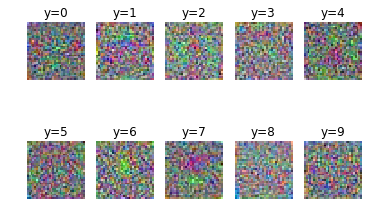

0.0

In [198]:
datasets = [train_X, train_Y , val_X, val_Y, test_X , test_Y]
base_params = {'batch_size':100, 'eta':0.001, 'n_epochs':1000, 'lamda':0}
train_model(base_params, datasets)

###  Plots graphs for training and validation

### Explore different Parameter Settings

In [164]:
params = [{'lamda': 0,   'epochs':  40, 'batch_size': 100, 'eta': .1},
            {'lamda': 0,   'epochs':  40, 'batch_size': 100, 'eta': .01},
            {'lamda': 0.1, 'epochs':  40, 'batch_size': 100, 'eta': .01},
            {'lamda': 1,   'epochs':  40, 'batch_size': 100, 'eta': .01},
        ]

test_results = []
for param in params:
    val_accuracy = train_model(batch_size=param['batch_size'], eta=param['eta'], n_epochs=param['n_epochs'], lamda=param['lamda'])
    test_results.append({**p, 'val_accuracy': accuracy})
    
df_test = pd.DataFrame(test_results)
df_test

NameError: name 'train_model' is not defined

In [172]:
a = [0,1]
b, c = a

In [173]:
b

0

In [174]:
c

1